In [1]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
from transformer_layers import *

In [2]:
T = 100
horizon = 4   # 0=10, 1=20, 2=30, 3=50, 4=100
#start_capital = 10000
day = 1
asset = 1

In [3]:
current_path = os.getcwd()
deeplob_model = load_model('static\deeplob_serving_model.h5', custom_objects={'PositionalEncodingLayer': PositionalEncodingLayer,
                                                                              "MultiHeadSelfAttention": MultiHeadSelfAttention,
                                                                              "TransformerTransition": TransformerTransition})

In [4]:
def load_lob_data(day, T=T):
    lob_data = np.loadtxt(f"static/data/lobdata_day_{day}.txt")
    lob_data = np.array(lob_data[:40, :].T)
    
    best_asks = lob_data[:,0]
    difference_best_asks = best_asks - np.roll(best_asks, 1)
    split = (abs(difference_best_asks) > 0.03).nonzero()[0]
    split = np.append(split, len(best_asks))

    lob_data_assets = {"all": lob_data}
    for i in range(5):
        lob_data_assets[f"asset_{i+1}"] = lob_data[split[i]:split[i+1], :]
        
    return lob_data_assets

In [5]:
def predict(lob_data, T=T, horizon=horizon):
    [N, D] = lob_data.shape
    df = np.array(lob_data)
    input_data = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        input_data[i - T] = df[i - T:i, :]
    input_data = input_data.reshape(input_data.shape + (1,))

    predictions = deeplob_model.predict(input_data)
    predicted_directions = np.argmax(predictions[:, horizon], axis=1)

    return predicted_directions

In [6]:
def backtester(lob_data, predictions):
    
    
    return backtest_df, backtest_kpis

In [7]:
lob_data = load_lob_data(2)

In [8]:
preds = predict(lob_data[f"asset_{asset}"])

C:\Users\sass9\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,ask,bid,prediction,shares_held,ask_change,bid_change,return,shares_held_change,profit,cumulative_profit,relative_return,cumulative_relative_return
99,0.2684,0.2679,0,0.0,NaN,NaN,0.0000,0.0,0.2684,0.2684,0.000000,1.000000
100,0.2684,0.2679,0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.2684,0.000000,1.000000
101,0.2684,0.2679,0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.2684,0.000000,1.000000
102,0.2684,0.2679,2,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.2684,0.000000,1.000000
103,0.2683,0.2679,2,0.0,-0.0001,0.0000,0.0000,1.0,0.0000,0.2684,0.000000,1.000000
104,0.2683,0.2679,2,1.0,0.0000,0.0000,0.0000,0.0,0.0000,0.2684,0.000000,1.000000
105,0.2681,0.2678,2,1.0,-0.0002,-0.0001,-0.0001,0.0,-0.0001,0.2683,-0.000373,0.999627
106,0.2681,0.2678,2,1.0,0.0000,0.0000,0.0000,-2.0,0.0000,0.2683,0.000000,0.999627
107,0.2681,0.2675,2,-1.0,0.0000,-0.0003,-0.0000,0.0,-0.0000,0.2683,0.000000,0.999627
108,0.2679,0.2675,2,-1.0,-0.0002,0.0000,0.0002,0.0,0.0002,0.2685,0.000745,1.000373


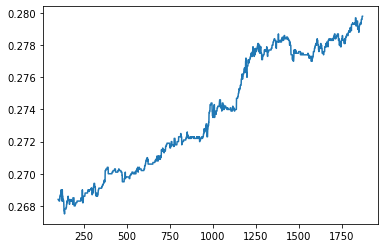

In [36]:
df = pd.DataFrame(data=lob_data[f"asset_{asset}"][:, [0,2]], columns=[ "ask", "bid"])
df = df.iloc[T-1: , :]
df["prediction"] = preds

df["shares_held"] = np.nan
df.loc[df["prediction"] == 0, "shares_held"] = 1
df.loc[df["prediction"] == 2, "shares_held"] = -1
df["shares_held"] = df["shares_held"].shift(5, fill_value=0)
df["shares_held"].fillna(method="ffill", inplace=True)

df["ask_change"] = df["ask"] - df["ask"].shift(1)
df["bid_change"] = df["bid"] - df["bid"].shift(1)

df["return"] = 0
df.loc[df["shares_held"] > 0, "return"] = df["bid_change"]
df.loc[df["shares_held"] < 0, "return"] = - df["ask_change"]

df["shares_held_change"] = df["shares_held"].shift(-1, fill_value=0) - df["shares_held"]
#df["cost"] = df["shares_held_change"] * (df["ask"] - df["bid"]) * (df["shares_held_change"] > 0)

df["profit"] = df["return"].copy()
df["profit"].iloc[0] = df["ask"].iloc[0].copy()
df["cumulative_profit"] = df["profit"].cumsum()

df["relative_return"] = (df["cumulative_profit"] - df["cumulative_profit"].shift(1)) / df["cumulative_profit"].shift(1)
df["relative_return"].iloc[0] = 0
df["cumulative_relative_return"] = (1 + df["relative_return"]).cumprod()

df["cumulative_profit"].plot()
#df["cumulative_relative_return"].plot()

df.head(20)

<AxesSubplot:>

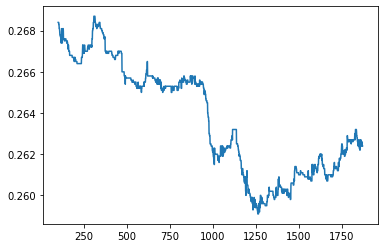

In [24]:
df["ask"].plot()

<AxesSubplot:>

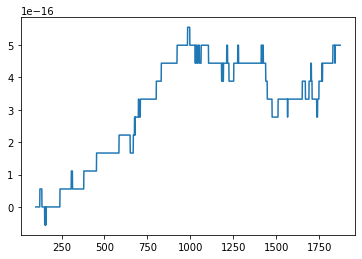

In [34]:
df["HODL"] = (1 + (df["ask_change"] / df["ask"].shift(1))).cumprod()

In [22]:
df["cumulative_profit"].iloc[-1]

-0.005800000000000027

In [17]:
df.index

RangeIndex(start=99, stop=1873, step=1)

In [18]:
df.index[0] = 1

TypeError: Index does not support mutable operations

In [21]:
df["shares_held_change"].iloc[-1]

1.0